### Import useful packages

In [96]:
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd # this module is useful to work with tabular data
import random # this module will be used to select random samples from a collection
import os # this module will be used just to create directories in the local filesystem
from tqdm import tqdm # this module is useful to plot progress bars

#import plotly_express as px #plotly_express = "0.4.0"
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import nn


### Define dataset from MNIST

In [97]:
### Download the data and create dataset
data_dir = 'dataset'
# With these commands the train and test datasets, respectively, are downloaded 
# automatically and stored in the local "data_dir" directory.
train_dataset = torchvision.datasets.FashionMNIST(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.FashionMNIST(data_dir, train=False, download=True)

### Define data transform to tensors and define dataloaders

In [98]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

train_dataset.transform = transform
test_dataset.transform = transform

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=256, shuffle=True
)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=256, shuffle=False
)

batch_data, batch_labels = next(iter(train_dataloader))
print(f"TRAIN BATCH SHAPE")
print(f"\t Data: {batch_data.shape}")# 256batch size 1  28*28 size of pics
print(f"\t Labels: {batch_labels.shape}")

batch_data, batch_labels = next(iter(test_dataloader))
print(f"TEST BATCH SHAPE")
print(f"\t Data: {batch_data.shape}")
print(f"\t Labels: {batch_labels.shape}")

TRAIN BATCH SHAPE
	 Data: torch.Size([256, 1, 28, 28])
	 Labels: torch.Size([256])
TEST BATCH SHAPE
	 Data: torch.Size([256, 1, 28, 28])
	 Labels: torch.Size([256])


### Define encoder and decoder

In [99]:
###encoder
class Encoder(nn.Module):
    def __init__(self, encoded_space_dim):
        super().__init__()

        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, 
                      stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, 
                      stride=2, padding=1), 
            nn.ReLU(True),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, 
                      stride=2, padding=0),
            nn.ReLU(True)
        )
        self.flatten = nn.Flatten(start_dim=1)
        self.encoder_lin = nn.Sequential(
            nn.Linear(in_features=3*3*32, out_features=64),
            nn.ReLU(True),
            nn.Linear(in_features=64, out_features=encoded_space_dim)
        )

    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        x = self.encoder_lin(x)
        return x



In [100]:
###decoder
class Decoder(nn.Module):
    def __init__(self, encoded_space_dim):

        super().__init__()
        self.decoder_lin = nn.Sequential(
            nn.Linear(in_features = encoded_space_dim, out_features=64),
            nn.ReLU(True),
            nn.Linear(in_features=64,out_features=3*3*32),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1,unflattened_size=(32, 3, 3))
        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, 
                               stride=2, output_padding=0),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=3, 
                               stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=8, out_channels=1, kernel_size=3, 
                               stride=2, padding=1, output_padding=1)
            
                            
        )
    def forward(self,x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x 

### Make preparation for training

In [101]:
### initialize the two networks

# Set the random seed for reproducible results
torch.manual_seed(2041389)

# Initialize the two networks
encoded_space_dim = 2
encoder = Encoder(encoded_space_dim=encoded_space_dim)
decoder = Decoder(encoded_space_dim=encoded_space_dim)

In [102]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)

Selected device: cpu


Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=64, out_features=288, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

In [103]:
### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr = 5e-4 # Learning rate 
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]
optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-5)

### Define Training function and testing function

In [104]:
### Training function
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer):

    encoder.train()
    decoder.train()
    for image_batch, _ in dataloader:
        image_batch = image_batch.to(device)
        encoded_data = encoder(image_batch)
        decoded_data = decoder(encoded_data)
        loss = loss_fn(decoded_data, image_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print('\t partial train loss (single batch): %f' % (loss.data)
)

In [105]:
### Testing function
def test_epoch(encoder,decoder,dataloader,loss_fn,device):
    encoder.eval()
    decoder.eval()
    conc_out = []
    conc_label = []
    for image_batch, _ in dataloader:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            # Encode data
            encoded_data = encoder(image_batch)
            # Decode data
            decoded_data = decoder(encoded_data)
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
    # Create a single tensor with all the values in the lists
    conc_out = torch.cat(conc_out)
    conc_label = torch.cat(conc_label) 
    # Evaluate global loss
    val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

### Start training

EPOCH 1/10
	 partial train loss (single batch): 0.149631
	 partial train loss (single batch): 0.148395
	 partial train loss (single batch): 0.150241
	 partial train loss (single batch): 0.148011
	 partial train loss (single batch): 0.147599
	 partial train loss (single batch): 0.146996
	 partial train loss (single batch): 0.148856
	 partial train loss (single batch): 0.147847
	 partial train loss (single batch): 0.148829
	 partial train loss (single batch): 0.146866
	 partial train loss (single batch): 0.147076
	 partial train loss (single batch): 0.145423
	 partial train loss (single batch): 0.148291
	 partial train loss (single batch): 0.147243
	 partial train loss (single batch): 0.148380
	 partial train loss (single batch): 0.146478
	 partial train loss (single batch): 0.144586
	 partial train loss (single batch): 0.147221
	 partial train loss (single batch): 0.143723
	 partial train loss (single batch): 0.146717
	 partial train loss (single batch): 0.149172
	 partial train loss (s

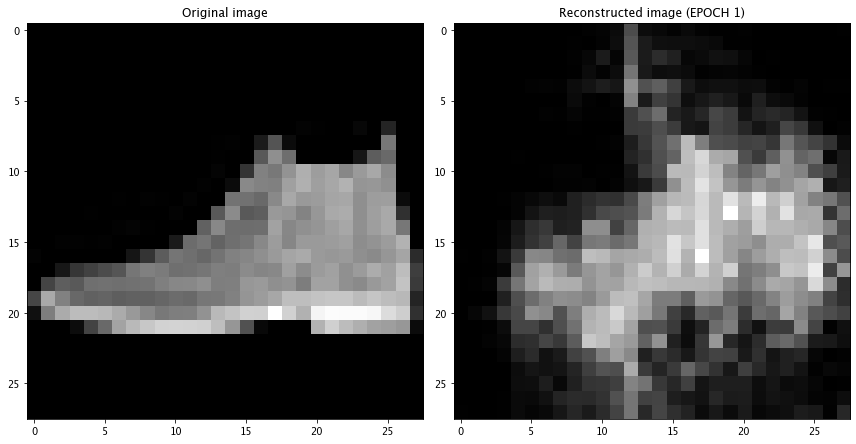

EPOCH 2/10
	 partial train loss (single batch): 0.068200
	 partial train loss (single batch): 0.066197
	 partial train loss (single batch): 0.064654
	 partial train loss (single batch): 0.063532
	 partial train loss (single batch): 0.062654
	 partial train loss (single batch): 0.062000
	 partial train loss (single batch): 0.064030
	 partial train loss (single batch): 0.062734
	 partial train loss (single batch): 0.058714
	 partial train loss (single batch): 0.061480
	 partial train loss (single batch): 0.060465
	 partial train loss (single batch): 0.061878
	 partial train loss (single batch): 0.061584
	 partial train loss (single batch): 0.059724
	 partial train loss (single batch): 0.057522
	 partial train loss (single batch): 0.059384
	 partial train loss (single batch): 0.056540
	 partial train loss (single batch): 0.062169
	 partial train loss (single batch): 0.057139
	 partial train loss (single batch): 0.056333
	 partial train loss (single batch): 0.057786
	 partial train loss (s

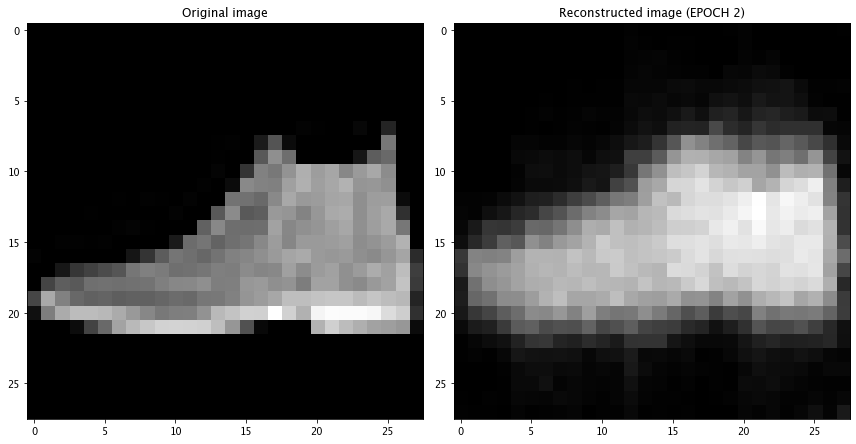

EPOCH 3/10
	 partial train loss (single batch): 0.042249
	 partial train loss (single batch): 0.040574
	 partial train loss (single batch): 0.040785
	 partial train loss (single batch): 0.041236
	 partial train loss (single batch): 0.042010
	 partial train loss (single batch): 0.041056
	 partial train loss (single batch): 0.039741
	 partial train loss (single batch): 0.038642
	 partial train loss (single batch): 0.040188
	 partial train loss (single batch): 0.042945
	 partial train loss (single batch): 0.041253
	 partial train loss (single batch): 0.040849
	 partial train loss (single batch): 0.039668
	 partial train loss (single batch): 0.041694
	 partial train loss (single batch): 0.040794
	 partial train loss (single batch): 0.041341
	 partial train loss (single batch): 0.040001
	 partial train loss (single batch): 0.042264
	 partial train loss (single batch): 0.039292
	 partial train loss (single batch): 0.041102
	 partial train loss (single batch): 0.044460
	 partial train loss (s

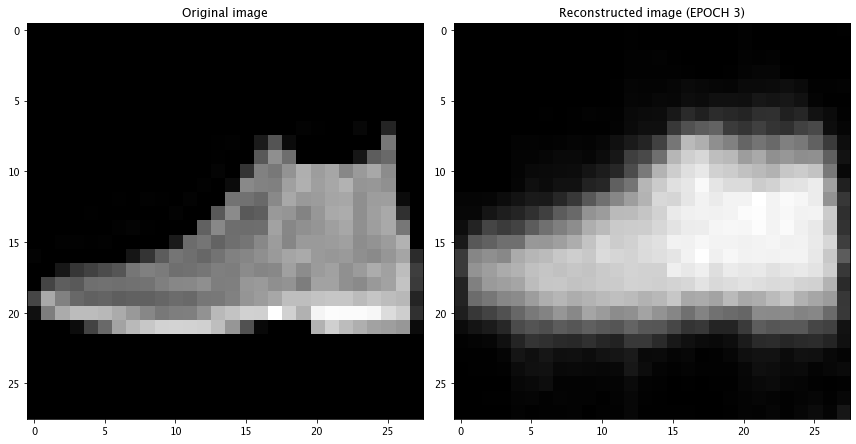

EPOCH 4/10
	 partial train loss (single batch): 0.038110
	 partial train loss (single batch): 0.037025
	 partial train loss (single batch): 0.035101
	 partial train loss (single batch): 0.038473
	 partial train loss (single batch): 0.038469
	 partial train loss (single batch): 0.039191
	 partial train loss (single batch): 0.037266
	 partial train loss (single batch): 0.037375
	 partial train loss (single batch): 0.036948
	 partial train loss (single batch): 0.040220
	 partial train loss (single batch): 0.039124
	 partial train loss (single batch): 0.038330
	 partial train loss (single batch): 0.039290
	 partial train loss (single batch): 0.038271
	 partial train loss (single batch): 0.036901
	 partial train loss (single batch): 0.039794
	 partial train loss (single batch): 0.039213
	 partial train loss (single batch): 0.039565
	 partial train loss (single batch): 0.040581
	 partial train loss (single batch): 0.040256
	 partial train loss (single batch): 0.040288
	 partial train loss (s

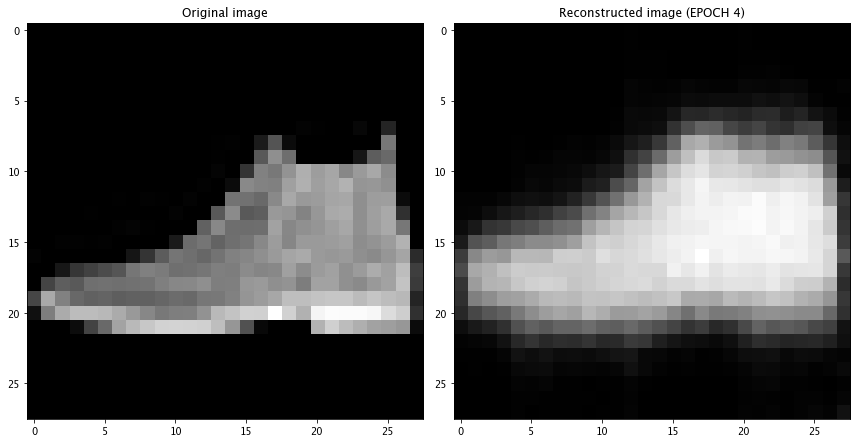

EPOCH 5/10
	 partial train loss (single batch): 0.035128
	 partial train loss (single batch): 0.037502
	 partial train loss (single batch): 0.038467
	 partial train loss (single batch): 0.037092
	 partial train loss (single batch): 0.039121
	 partial train loss (single batch): 0.038390
	 partial train loss (single batch): 0.034732
	 partial train loss (single batch): 0.034876
	 partial train loss (single batch): 0.038598
	 partial train loss (single batch): 0.038285
	 partial train loss (single batch): 0.037502
	 partial train loss (single batch): 0.035350
	 partial train loss (single batch): 0.037458
	 partial train loss (single batch): 0.037409
	 partial train loss (single batch): 0.037448
	 partial train loss (single batch): 0.037771
	 partial train loss (single batch): 0.037270
	 partial train loss (single batch): 0.038970
	 partial train loss (single batch): 0.038659
	 partial train loss (single batch): 0.037217
	 partial train loss (single batch): 0.038242
	 partial train loss (s

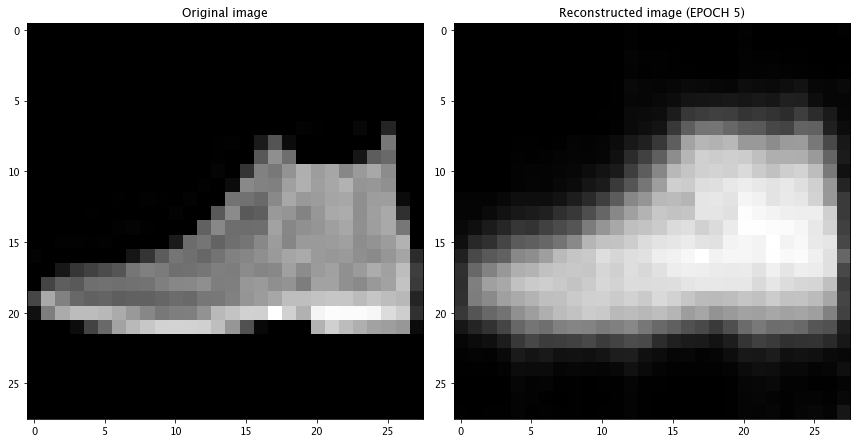

EPOCH 6/10
	 partial train loss (single batch): 0.034258
	 partial train loss (single batch): 0.034233
	 partial train loss (single batch): 0.034870
	 partial train loss (single batch): 0.037616
	 partial train loss (single batch): 0.036910
	 partial train loss (single batch): 0.035862
	 partial train loss (single batch): 0.036751
	 partial train loss (single batch): 0.036548
	 partial train loss (single batch): 0.035742
	 partial train loss (single batch): 0.037241
	 partial train loss (single batch): 0.037305
	 partial train loss (single batch): 0.034896
	 partial train loss (single batch): 0.034288
	 partial train loss (single batch): 0.036654
	 partial train loss (single batch): 0.038030
	 partial train loss (single batch): 0.036166
	 partial train loss (single batch): 0.036491
	 partial train loss (single batch): 0.036011
	 partial train loss (single batch): 0.034069
	 partial train loss (single batch): 0.033579
	 partial train loss (single batch): 0.035688
	 partial train loss (s

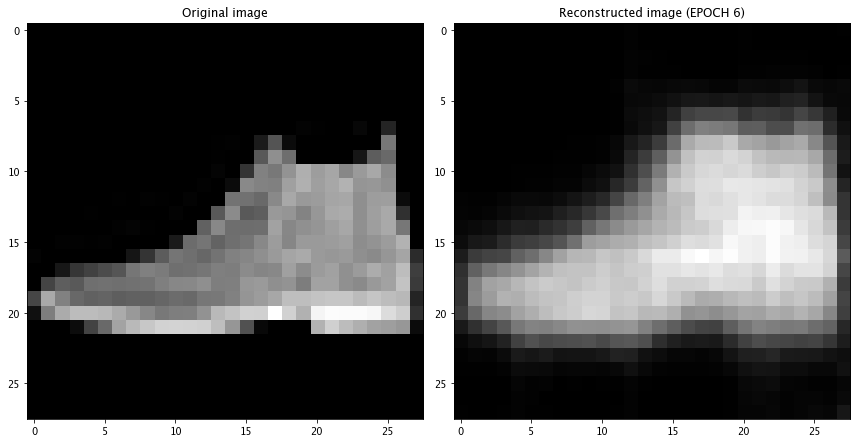

EPOCH 7/10
	 partial train loss (single batch): 0.034290
	 partial train loss (single batch): 0.034962
	 partial train loss (single batch): 0.033243
	 partial train loss (single batch): 0.035924
	 partial train loss (single batch): 0.034378
	 partial train loss (single batch): 0.035144
	 partial train loss (single batch): 0.035888
	 partial train loss (single batch): 0.032344
	 partial train loss (single batch): 0.032783
	 partial train loss (single batch): 0.034772
	 partial train loss (single batch): 0.032158
	 partial train loss (single batch): 0.034968
	 partial train loss (single batch): 0.032523
	 partial train loss (single batch): 0.033697
	 partial train loss (single batch): 0.035104
	 partial train loss (single batch): 0.036425
	 partial train loss (single batch): 0.033949
	 partial train loss (single batch): 0.032329
	 partial train loss (single batch): 0.033644
	 partial train loss (single batch): 0.035180
	 partial train loss (single batch): 0.033824
	 partial train loss (s

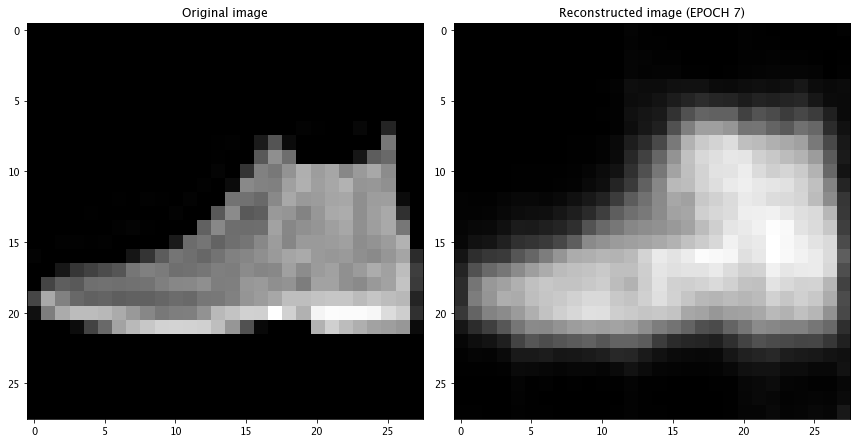

EPOCH 8/10
	 partial train loss (single batch): 0.035708
	 partial train loss (single batch): 0.034256
	 partial train loss (single batch): 0.033709
	 partial train loss (single batch): 0.031854
	 partial train loss (single batch): 0.035569
	 partial train loss (single batch): 0.033552
	 partial train loss (single batch): 0.032702
	 partial train loss (single batch): 0.034205
	 partial train loss (single batch): 0.032736
	 partial train loss (single batch): 0.033118
	 partial train loss (single batch): 0.033426
	 partial train loss (single batch): 0.034524
	 partial train loss (single batch): 0.032385
	 partial train loss (single batch): 0.032545
	 partial train loss (single batch): 0.031864
	 partial train loss (single batch): 0.031677
	 partial train loss (single batch): 0.032083
	 partial train loss (single batch): 0.033683
	 partial train loss (single batch): 0.031572
	 partial train loss (single batch): 0.032256
	 partial train loss (single batch): 0.032977
	 partial train loss (s

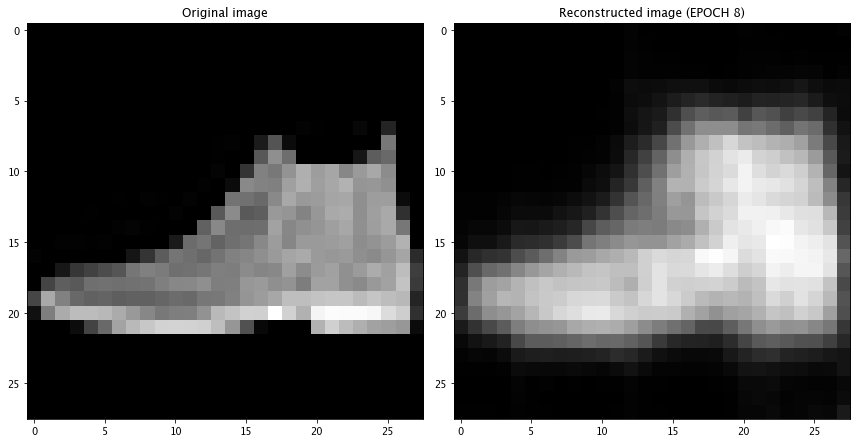

EPOCH 9/10
	 partial train loss (single batch): 0.035260
	 partial train loss (single batch): 0.032184
	 partial train loss (single batch): 0.031685
	 partial train loss (single batch): 0.033426
	 partial train loss (single batch): 0.033108
	 partial train loss (single batch): 0.031095
	 partial train loss (single batch): 0.031577
	 partial train loss (single batch): 0.030908
	 partial train loss (single batch): 0.033504
	 partial train loss (single batch): 0.032932
	 partial train loss (single batch): 0.030347
	 partial train loss (single batch): 0.031957
	 partial train loss (single batch): 0.031554
	 partial train loss (single batch): 0.033654
	 partial train loss (single batch): 0.031429
	 partial train loss (single batch): 0.033717
	 partial train loss (single batch): 0.031648
	 partial train loss (single batch): 0.031919
	 partial train loss (single batch): 0.032697
	 partial train loss (single batch): 0.030525
	 partial train loss (single batch): 0.031523
	 partial train loss (s

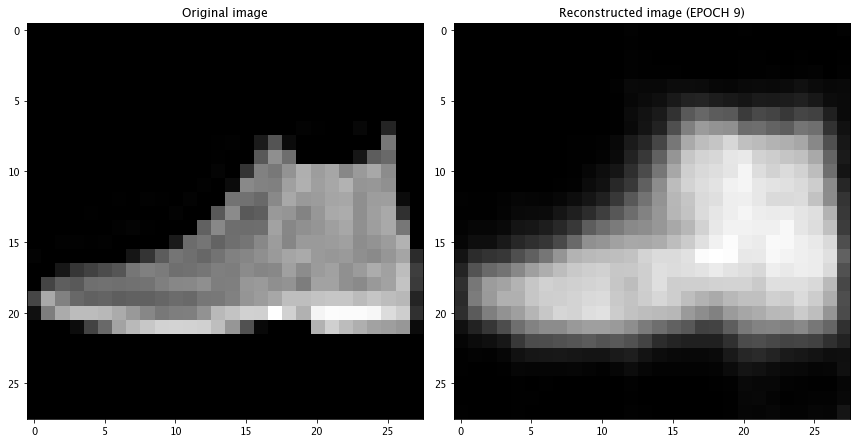

EPOCH 10/10
	 partial train loss (single batch): 0.029882
	 partial train loss (single batch): 0.031051
	 partial train loss (single batch): 0.034402
	 partial train loss (single batch): 0.028912
	 partial train loss (single batch): 0.031615
	 partial train loss (single batch): 0.031461
	 partial train loss (single batch): 0.031841
	 partial train loss (single batch): 0.032471
	 partial train loss (single batch): 0.031148
	 partial train loss (single batch): 0.032684
	 partial train loss (single batch): 0.032367
	 partial train loss (single batch): 0.032432
	 partial train loss (single batch): 0.030005
	 partial train loss (single batch): 0.031654
	 partial train loss (single batch): 0.034242
	 partial train loss (single batch): 0.030989
	 partial train loss (single batch): 0.031825
	 partial train loss (single batch): 0.032103
	 partial train loss (single batch): 0.032012
	 partial train loss (single batch): 0.031689
	 partial train loss (single batch): 0.031357
	 partial train loss (

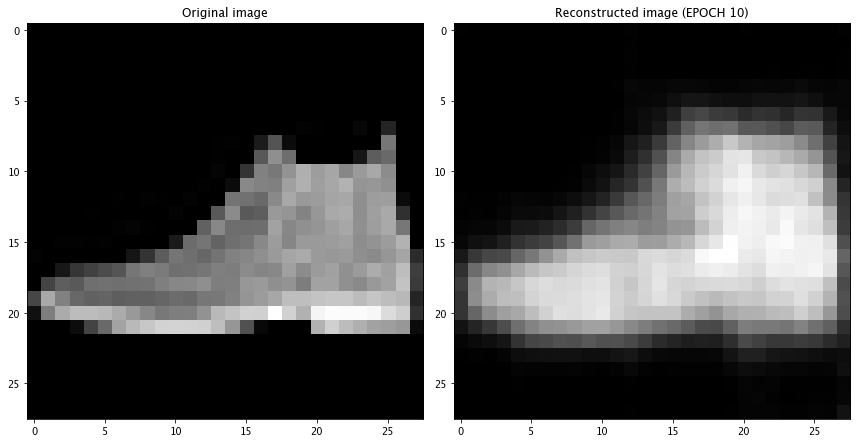

In [106]:
### Training cycle
num_epochs = 10
for epoch in range(num_epochs):
    print('EPOCH %d/%d' % (epoch + 1, num_epochs))
    ### Training (use the training function)
    train_epoch(
        encoder=encoder, 
        decoder=decoder, 
        device=device, 
        dataloader=train_dataloader, 
        loss_fn=loss_fn, 
        optimizer=optim)
    ### Validation  (use the testing function)
    val_loss = test_epoch(
        encoder=encoder, 
        decoder=decoder, 
        device=device, 
        dataloader=test_dataloader, 
        loss_fn=loss_fn)
    # Print Validationloss
    print('\n\n\t VALIDATION - EPOCH %d/%d - loss: %f\n\n' % (epoch + 1, num_epochs, val_loss))

    ### Plot progress
    # Get the output of a specific image (the test image at index 0 in this case)
    img = test_dataset[0][0].unsqueeze(0).to(device)
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        rec_img  = decoder(encoder(img))
    # Plot the reconstructed image
    fig, axs = plt.subplots(1, 2, figsize=(12,6))
    axs[0].imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
    axs[0].set_title('Original image')
    axs[1].imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
    axs[1].set_title('Reconstructed image (EPOCH %d)' % (epoch + 1))
    plt.tight_layout()
    plt.pause(0.1)
    # Save figures
    os.makedirs('autoencoder_progress_%d_features' % encoded_space_dim, exist_ok=True)
    fig.savefig('autoencoder_progress_%d_features/epoch_%d.jpg' % (encoded_space_dim, epoch + 1))
    plt.show()
    plt.close()

    # Save network parameters
    torch.save(encoder.state_dict(), 'encoder_params.pth')
    torch.save(decoder.state_dict(), 'decoder_params.pth')

    # NOTE: Remember to save also the parameters of the optimizer if you want to restore and continue the training

### Plot reconstructed image

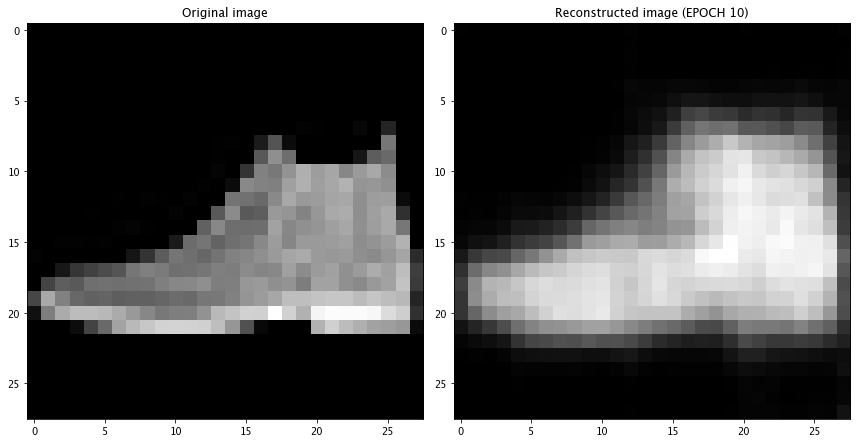

In [107]:
 # Plot the reconstructed image
fig, axs = plt.subplots(1, 2, figsize=(12,6))
axs[0].imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
axs[0].set_title('Original image')
axs[1].imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
axs[1].set_title('Reconstructed image (EPOCH %d)' % (epoch + 1))

plt.tight_layout()
plt.pause(0.1)

### Save figures and network parameters

In [110]:
# Save figures
os.makedirs('autoencoder_progress_%d_features' % encoded_space_dim, exist_ok=True)
fig.savefig('autoencoder_progress_%d_features/epoch_%d.jpg' % (encoded_space_dim, epoch + 1))
plt.show()
plt.close()

# Save network parameters
torch.save(encoder.state_dict(), 'encoder_params.pth')
torch.save(decoder.state_dict(), 'decoder_params.pth')

In [111]:
# Load network parameters
encoder.load_state_dict(torch.load('encoder_params.pth'))
decoder.load_state_dict(torch.load('decoder_params.pth'))


### Get the encoded representation of the test samples
encoded_samples = []
for sample in tqdm(test_dataset):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    encoder.eval()
    with torch.no_grad():
        encoded_img  = encoder(img)

    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)

# Convert to a dataframe
encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples

100%|██████████| 10000/10000 [00:04<00:00, 2177.40it/s]


,Enc. Variable 0,Enc. Variable 1,label
0,-0.236477,-11.032328,9
1,-38.403770,24.361818,2
2,2.083142,39.703358,1
3,5.986742,24.625530,1
4,-13.807528,6.555387,6
...,...,...,...
9995,-5.526461,-24.383318,9
9996,5.995608,15.256278,1
9997,-4.758934,-3.355727,8
9998,10.837448,31.244268,1


### Show latent space structure

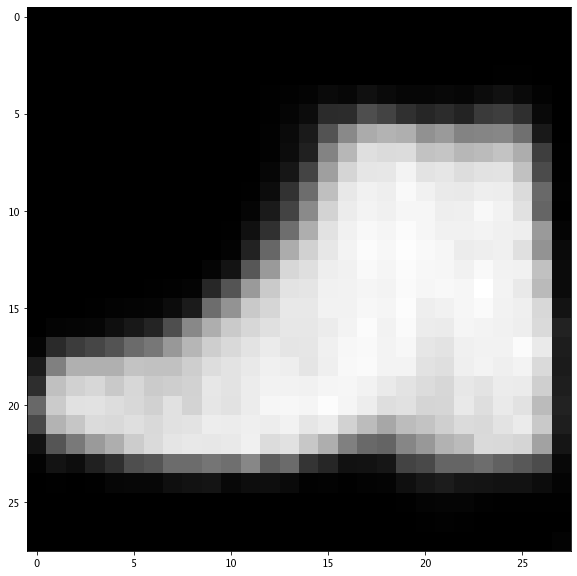

In [112]:
if encoded_space_dim == 2:
    # Generate a custom sample
    custom_encoded_sample = [-6, -30.0]
    encoded_value = torch.tensor(custom_encoded_sample).float().unsqueeze(0).to(device)

    # Decode sample
    decoder.eval()
    with torch.no_grad():
        generated_img  = decoder(encoded_value)

    plt.figure(figsize=(12,10))
    plt.imshow(generated_img.squeeze().cpu().numpy(), cmap='gist_gray')
    plt.show()

### Using PCA 

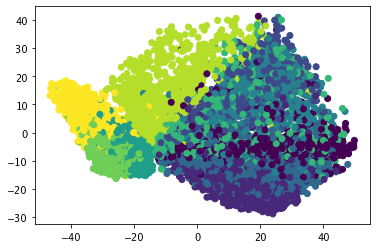

In [113]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
encoded_samples_reduced_PCA = pca.fit_transform(encoded_samples)
encoded_samples_reduced_PCA
plt.scatter(encoded_samples_reduced_PCA[:,0], encoded_samples_reduced_PCA[:,1], c=encoded_samples.label.to_numpy())